# Mini-Project

In this module we are going to put everything we studied so far together. We will build a pipeline that contains both supervised and unsupervised tasks. Using again the Swiss Food Composition dataset, we will train a model that will be able to distinguish between `cereals` and `other` food categories, using the dataset with all the features and then the dimensionality reduced dataset.

[Figure 1](#ml_pipeline) gives an illustration of the pipeline in both cases.

<center>
    <a id="ml_pipeline"></a>
    <img src="images/mini_project/ml_pipeline_in_project.jpg" alt="ML Pipeline" width="80%" height="60%">
    <center><figcaption><em>Figure 1: ML Pipeline Illustration</em></figcaption></center>
</center>

In the code snippets below, we are going to train a `RandomForestClassifier`, first in the dataset with all the features and then in the dimensionality reduced dataset using `UMAP`.

## Read the data

As usual, we will start by importing the necessary libraries, defining some helper functions and reading the data. We will use the processed version of the Swiss Food Composition Dataset that we used in the previous modules (`data/swiss_food_composition_proc.csv`).

In [33]:
# general packages
import pandas as pd
import os

# packages for performance evaluation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# packages for classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.manifold import TSNE
from umap import  UMAP

# we need these packages for visualizing the results
import seaborn as sns
import matplotlib.pyplot as plt

Here we read the dataset and store it in the `dataset` variable.

In [34]:
# we will work with the preprocessed dataset
filepath = os.path.join("data", "swiss_food_composition_proc.csv")
dataset = pd.read_csv(filepath, index_col='ID')
# save the numerical columns in the numerical_cols variable
numerical_cols = dataset.select_dtypes(include='number').columns
dataset.head()

,name,category,energy_kcal,fat_g,fatty_acids_sat_g,fatty_acids_monounsat_g,fatty_acids_polyunsat_g,cholesterol_mg,carbohydrates_g,sugars_g,...,potassium_mg,sodium_mg,chloride_mg,calcium_mg,magnesium_mg,phosphorus_mg,iron_mg,iodide_µg,zinc_mg,split
ID,,,,,,,,,,,,,,,,,,,,,
2,Almond,fruits,2.383884,2.367211,0.007568,3.747869,1.491113,-0.536758,-0.392082,0.004006,...,1.588591,-0.159777,-0.148160,1.295299,4.040213,2.312243,0.749351,-0.106408,1.315695,train
3,"Almond, dry roasted, salted",nuts,2.458504,2.390231,0.007568,3.980279,1.745907,-0.536758,-0.285661,-0.117252,...,1.488645,-0.083438,0.108003,1.295299,4.816868,2.059374,0.906205,-0.088162,1.315695,train
4,"Almond, roasted, salted",nuts,2.527384,2.545613,0.020843,4.212688,1.825530,-0.536758,-0.419844,-0.138650,...,1.355384,-0.050088,0.108003,1.098111,4.622704,2.059374,0.749351,-0.088162,1.185016,test
5,"Amaranth, seed, cooked (without addition of fa...",cereals,-0.514820,-0.510234,-0.483593,-0.476516,-0.196900,-0.536758,0.084497,-0.431096,...,-0.377014,-0.159511,-0.149051,-0.098161,1.011260,0.226077,0.631711,-0.101432,-0.056440,test
6,"Amaranth, seed, raw",cereals,0.960362,-0.228244,-0.337572,-0.312462,0.121593,-0.536758,1.875138,-0.345502,...,0.722392,-0.158810,-0.132568,0.572278,4.234377,2.628328,2.984515,-0.087333,1.577054,train


## Define helper functions

In this section we are going to define some helper functions that we will need later for the training and evaluation of the models. You do not need to understand what these functions do to complete the project. Also you should not change anything within these functions.

In [35]:
def get_train_test_sets(dataset:pd.DataFrame, feature_cols:list, target_col:str):
    '''
    Function used to split the dataset into train and test sets and return the train
    and test features and target variables. The split is based on the pre-processing steps 
    included in the clean_chocolate_dataset.py script.

    Args:
     - dataset: the dataset that will be split
     - feature_cols: a list with the names of the feature columns
     - target_col: a string with the name of the target column

    Returns:
     - four pandas dataframes containing the train features, train targets,
     test features and test targets.
    '''

    train_data = dataset[dataset['split'] == 'train']
    test_data = dataset[dataset['split'] == 'test']
    
    return train_data[feature_cols], train_data[target_col], \
        test_data[feature_cols], test_data[target_col]

def encode_label_category(label:str, label_column:pd.Series):
    '''
    This function converts the label_column to a column containing binary values
    of 0 or 1. The rows whose value will be equal to `label` value will contain a 1. All
    the other rows will contain a 0.

    Args:
        - label: the category that will be encoded with 1
        - label_column: the column that will be transformed

    Return:
    The transformed column.
    '''
    return label_column.apply(lambda x: 1 if x == label else 0)

def prepare_dataset(label:str, original_dataset:pd.DataFrame):
    
    ''' 
    This function is used to prepare the original dataset for the next steps in 
    supervised learning. It extracts the labels, does the manual encoding of the 
    category specified in the label parameter and splits the dataset into train and 
    test based on the split from Module 1. Also, here the features and labels are
    splitted in different dataframes.

    Args: 
        - label: the category that will be classified
        - original_datatset: the dataset
    
    Returns:
        - train_features, test_features, train_labels, test_labels
    '''
    
    labels_col = original_dataset['category']
    
    one_hot_labels = encode_label_category(label=label, label_column=labels_col)
    
    original_dataset['category_binary'] = one_hot_labels
    
    not_needed_cols = ['name', 'category', 'split', 'category_binary']
    feature_cols = original_dataset.columns.difference(not_needed_cols)
    target_col = 'category_binary'

    return get_train_test_sets(original_dataset, feature_cols=feature_cols,\
                                target_col=target_col)

In [36]:
def run_auc_roc_prc(clf, X_train:pd.DataFrame, X_test:pd.DataFrame, 
                    y_train:pd.DataFrame, y_test:pd.DataFrame, sup_title:str, 
                    dim_red:str):

    '''
    This function is used to visualize the ROC and PRC curves, as well as to
    calculate and display the accuracy and F1 scores. 

    Args:
     - clf: the classifier
     - X_train: is the features of the train set
     - X_test: is the features of the test set
     - y_train: the labels of the train set
     - y_test: the labels of the test set
     - sup_title: the title of the plot
     - dim_red: is the variable that indicates if/what
     dimensionality reduction technique is used

    Returns: nothing
    '''

    roc_title = f'ROC - curve'
      
    print(f"Accuracy (Test): {accuracy_score(y_true=y_test, y_pred=clf.predict(X_test)):.2f}")
    print(f"F1-score (Test): {f1_score(y_true=y_test, y_pred=clf.predict(X_test)):.2f}")
    print(f"Accuracy (Train): {accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)):.2f}")
    print(f"F1-score (Train): {f1_score(y_true=y_train, y_pred=clf.predict(X_train)):.2f}")

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    ax.set_title(roc_title)
    RocCurveDisplay.from_estimator(clf, X_test, y_test, \
        name="Test set", ax=ax, alpha=0.8, plot_chance_level=True)
    RocCurveDisplay.from_estimator(clf, X_train, y_train, \
        name="Train set", ax=ax, alpha=0.8)

    img_filepath = os.path.join("images", "plots",f'{sup_title.replace(" ", "_")}_{dim_red}')
    
    plt.suptitle(sup_title)
    plt.show()
    # save the figure in the plots folder
    fig.savefig(filepath, bbox_inches='tight')
    print(f'Plot saved in {img_filepath}')

In [37]:
def run_classifier(classifier, clf_type:str, dataset:pd.DataFrame, dim_red:str="no_dim_red"):
    '''
    This function splits the dataset into the train and test sets. Then it trains the 
    classifier model. Afterwards the results are visualized by calling the 
    run_auc_roc_prc() helper function.

    Args:
     - classifier: the model that will be trained and evaluated
     - clf_type: the type of classifier
     - dataset: a pandas dataframe containing the dataset
     - dim_red: is the variable that indicates what dimensionality
     reduction technique is used
    
    Returns: nothing
    '''
    # split the dataset into train and test set
    train_data_features, train_data_labels,\
        test_data_features, test_data_labels \
            = prepare_dataset(label="cereals", original_dataset=dataset)
    
    classifier.fit(train_data_features, train_data_labels.values.ravel())
    
    title=''
    if clf_type=="lr":
        title = 'Logistic Regression'
    elif clf_type=="rf":
        title = 'Random Forest'
    
    # visualize the results
    run_auc_roc_prc(classifier, X_train=train_data_features, 
                                   y_train=train_data_labels, X_test=test_data_features,
                                   y_test=test_data_labels, sup_title=title, dim_red=dim_red)

In [38]:
def run_dimensionality_reduction(dimensionality_reducer, dataset:pd.DataFrame, 
                                 numerical_cols:list):
    '''
    This method creates the dimensionality reduced dataset using the fit_transform method. 
    The results of dimensionality reduction are saved in a pandas dataframe that 
    contain the 4 columns holding the new, reduced dimensions as well as the category 
    of the sample and the split (`train` or `test`). 

    Args:
     - dimensionality_reducer: the object that will do the reduction
     - dataset: a pandas dataframe containing the data
     - numerical_cols: a list of the columns containing numerical data

    Returns: a pandas dataframe representing the dataset in low dimensions
    '''  
    
    low_dim_components = pd.DataFrame(
                        data=dimensionality_reducer.fit_transform(dataset[numerical_cols]), 
                        columns=['dim_1', 'dim_2'],
                        index=dataset.index #this is important for the concatenation in the next command
                        )

    data_after_dim_red = pd.concat([low_dim_components, dataset['category'], dataset['split']], axis=1)
    data_after_dim_red.columns = ['dim_1', 'dim_2', 'category', 'split']

    return data_after_dim_red   

## Model with all features

After having loaded the dataset and defined the helper functions we are ready to initialize, train and evaluate a model's performance. As an example, we will train a `RandomForestClassifer` with 30 trees, each of which has at most 4 levels.

After that, we create the plot title by calling the `get_plot_title` helper function. The actual training happens inside the `run_classifier` helper function. Below you can see the performance metrics of this model.

Accuracy (Test): 0.95
F1-score (Test): 0.78
Accuracy (Train): 0.97
F1-score (Train): 0.88


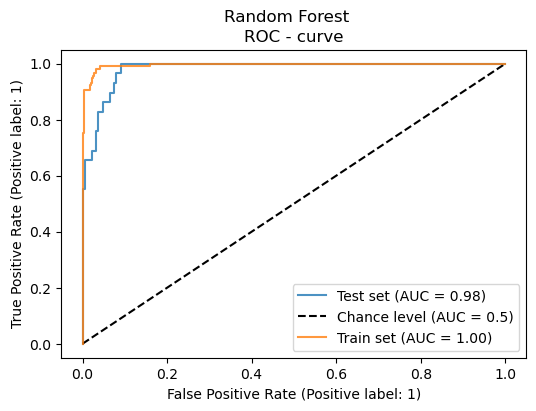

Plot saved in images/plots/Random_Forest_no_dim_red.png


In [39]:
# classifier hyperparameters
n_estimators = 30
max_depth = 4
###### CODE TO BE CHANGED ######
clf_type = 'rf' # change this to `lr` when using Logistic Regression 

# initialize the classifier here
classifier = RandomForestClassifier(max_depth=max_depth,\
                                        n_estimators=n_estimators,\
                                            random_state=0)

###### END CODE TO BE CHANGED ######

# train classifier and visualize results
run_classifier(classifier=classifier, clf_type=clf_type, dataset=dataset, dim_red="no_dim_red")

## Model with reduced features

In this scenario, we will use a setup similar to the previous one. However, there will be an extra step in the pipeline. Now the  model that we initialize is not trained on the dataset with all the features but instead in a dimensionality reduced dataset. Here we will use again a `RandomForestClassifier` with the same hyperparameters as above. We will use UMAP for dimensionality reduction. We will initialize the `umap` model with `n_neighbors=30` and `min_dist=0.5`. As usual, the number of components will be 2. By calling the `run_dimensionality_reduction` helper function we create the dimensionality reduced dataset. Having done this, we initialize the classifier, generate the plot title and then train the model and visualize the results by calling the `run_classifier` function.

Accuracy (Test): 0.93
F1-score (Test): 0.65
Accuracy (Train): 0.94
F1-score (Train): 0.75


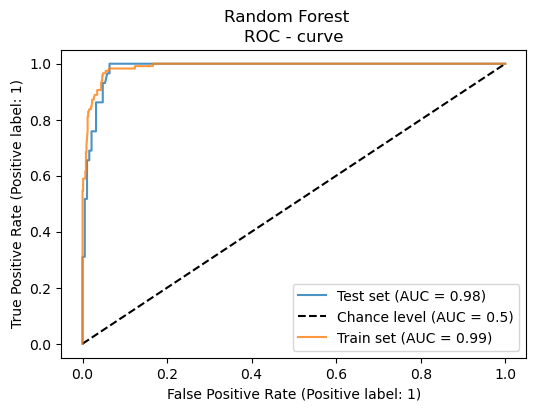

Plot saved in images/plots/Random_Forest_umap.png


In [40]:
# classifier hyperparameters
n_estimators = 30
max_depth = 4
clf_type = 'rf' # change this to `lr` when using Logistic Regression 

# dimensionality reduction hyperparameters
n_neighbors = 30
min_dist = 0.5
n_components = 2

###### CODE TO BE CHANGED ######
dim_red="umap" # Change this to `tsne` when running

# initialize dimensionality reduction technique
umap = UMAP(n_components=2, n_neighbors=n_neighbors, \
                min_dist=min_dist, random_state=0)

data_after_dimensionality_reduction = \
    run_dimensionality_reduction(umap, dataset=dataset, numerical_cols=numerical_cols)

# initialize classifier
classifier = RandomForestClassifier(max_depth=max_depth,\
                                        n_estimators=n_estimators,\
                                            random_state=0)

###### END CODE TO BE CHANGED ######

# train classifier and visualize the results
run_classifier(classifier=classifier, clf_type=clf_type, \
    dataset=data_after_dimensionality_reduction, dim_red=dim_red)

## Questions

1️⃣ Given the results obtained above in both scenarios, do you think the extra step of dimensionality reduction helps the model in learning the data better? What do the performance metrics indicate?

2️⃣ Now we need to test the performance of the `RandomForestClassifier` when the dimensionality technique used is `tSNE` with `perplexity=20` and `random_state=0`. For this you will need to change the code. Record both F1-scores and accuracy scores on the train and test sets in the new set up in the table below.

❗ **NOTE**: You will only need to initialize the `tSNE` object and use it instead of the `umap` object. There is only a single code cell where you would need to make changes in the code. **DO NOT FORGET TO CHANGE THE VALUE OF THE `dim_red` VARIABLE TO `tsne`, OTHERWISE THE PLOTS WILL NOT BE SAVED.**


3️⃣ Now we need to test the performance of the `LogisticRegression` classifier without dimensionality reduction. For this you will need to change the code when initializing the `RandomForestClassifier`. No hyperparameters are needed int his case. Record both F1-scores and accuracy scores on the train and test sets in the new set up in the table below.

❗ **NOTE**: You will only need to initialize the `LogisticRegression` object and pass it to the `run_classifier` function. There is only a single code cell where you would need to make changes in the code. **DO NOT FORGET TO CHANGE THE `clf_type='lr'`.**

4️⃣ Now we need to test the performance of the `LogisticRegression` classifier when the  dimensionality reduction technique used is `tSNE`. The `perplexity` should be set to 30 again. Record both F1-scores and accuracy scores on the train and test sets in the new set up in the table below.

❗ **NOTE**: In case you have followed the steps accordingly so far, you can obtain these results just by running the appropriate code cell.

5️⃣ As the final step, we need to test the performance of the `LogisticRegression` classifier when the  dimensionality reduction technique used is `UMAP` with `n_neighbors=30`, `min_dist=0.5`, `random_state=0` and `n_components=2`. Record both F1-scores and accuracy scores on the train and test sets in the new set up in the table below.

❗ **NOTE**: In case you have followed the steps accordingly so far, you will only need to initialize the `UMAP` object and use it instead of the `tSNE` object. There is only a single code cell where you would need to make changes in the code. **DO NOT FORGET TO CHANGE THE VALUE OF THE `dim_red` VARIABLE TO `umap`, OTHERWISE THE PLOTS WILL NOT BE SAVED.**

<center>
<table style="border: 3px solid black; text-align: center; color: black;">
    <tr>
        <td rowspan="3"></td>
        <td colspan="6" style="border-left: 4px solid black; border-right: 4px solid black; border-bottom: 3px solid black;">F1</td>
        <td colspan="6" style="border-bottom: 3px solid black;">Accuracy</td>
    </tr>
    <tr>
        <td colspan="2" style="border-left: 4px solid black; border-bottom: 3px solid black;">No dim. red.</td>
        <td colspan="2" style="border-left: 3px solid black; border-bottom: 3px solid black;">UMAP</td>
        <td colspan="2" style="border-left: 3px solid black; border-bottom: 3px solid black;">tSNE</td>
        <td colspan="2" style="border-left: 4px solid black; border-bottom: 3px solid black;">No dim. red.</td>
        <td colspan="2" style="border-left: 3px solid black; border-bottom: 3px solid black;">UMAP</td>
        <td colspan="2" style="border-left: 3px solid black; border-bottom: 3px solid black;">tSNE</td>
    </tr>
    <tr>
        <td style=" border-left: 4px solid black; border-bottom: 3px solid black;"">Train</td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">Test</td>
        <td style=" border-left: 3px solid black; border-bottom: 3px solid black;"">Train</td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">Test</td>
        <td style="border-left: 3px solid black; border-bottom: 3px solid black;">Train</td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">Test</td>
        <td style="border-left: 4px solid black; border-bottom: 3px solid black;">Train</td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">Test</td>
        <td style=" border-left: 3px solid black; border-bottom: 3px solid black;"">Train</td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">Test</td>
        <td style=" border-left: 3px solid black; border-bottom: 3px solid black;"">Train</td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">Test</td>
    </tr>
    <tr>
        <td style="border-bottom: 3px solid black; border-top: 3px solid black;">Random Forest</td>
        <td style="border-left: 4px solid black; border-bottom: 3px solid black;">
            <!--Place the F1 score no dim red train set value here-->0.88
        </td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">
            <!--Place F1 score no dim red test set value here-->0.78
        </td>
        <td style="border-left: 3px solid black;border-bottom: 3px solid black;">
            <!--Place the F1 score UMAP train set value here--> 0.75
        </td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">
            <!--Place F1 score UMAP test set value here-->0.65
        </td>
        <td style="border-left: 3px solid black; border-bottom: 3px solid black;">
            <!--Place the F1 score tSNE train set value here-->
        </td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">
            <!--Place the F1 score tSNE test set value here-->
        </td>
        <td style="border-left: 4px solid black; border-bottom: 3px solid black;">
            <!--Place the the accuracy score no dim red train set value here-->0.97
        </td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">
            <!--Place the accuracy score no dim red test set value here-->0.95
        </td>
        <td style="border-left: 3px solid black; border-bottom: 3px solid black;">
            <!--Place the accuracy score UMAP train set value here-->0.94
        </td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">
            <!--Place the accuracy score UMAP test set value here-->0.93
        </td>
        <td style="border-left: 3px solid black; border-bottom: 3px solid black;">
            <!--Place the accuracy score tSNE train set value here-->
        </td>
        <td style="border-left: 2px solid black; border-bottom: 3px solid black;">
            <!--Place the accuracy score tSNE test set value here-->
        </td>
    </tr>
    <tr>
        <td>Logistic Regression</td>
        <td style="border-left: 4px solid black;">
            <!--Place the F1 score no dim red train set value here-->
        </td>
        <td style="border-left: 2px solid black;">
            <!--Place F1 score no dim red test set value here-->
        </td>
        <td style="border-left: 3px solid black;">
            <!--Place the F1 score UMAP train set value here-->
        </td>
        <td style="border-left: 2px solid black;">
            <!--Place F1 score UMAP test set value here-->
        </td>
        <td style="border-left: 3px solid black;">
            <!--Place the F1 score tSNE train set value here-->
        </td>
        <td style="border-left: 2px solid black;">
            <!--Place the F1 score tSNE test set value here-->
        </td>
        <td style="border-left: 4px solid black;">
            <!--Place the accuracy score no dim red train set value here-->
        </td>
        <td style="border-left: 2px solid black;">
            <!--Place the accuracy score no dim red test set value here-->
        </td>
        <td style="border-left: 3px solid black;">
            <!--Place the accuracy score UMAP train set value here-->
        </td>
        <td style="border-left: 2px solid black;">
            <!--Place the accuracy score UMAP test set value here-->
        </td>
        <td style="border-left: 3px solid black;">
            <!--Place the accuracy score tSNE train set value here-->
        </td>
        <td style="border-left: 2px solid black;">
            <!--Place the accuracy score tSNE test set value here-->
        </td>
    </tr>
</table>
</center>


6️⃣ After having collected the results in the above table, which model do you think has the best performance? Why? Are there any indications of overfitting or underfitting? You can find all the plots saved in the `/images/plots/` folder.